In [2]:
from IPython.core.display import HTML
HTML("\n".join(open('mioti_style.css', 'r').readlines()))

<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Worksheet S4: Manejo de enumerados, árboles de decisión y curvas ROC

## Objetivos

Los objetivos de este worksheet son que:

* Aprendas a tratar con atributos enumerados
* Aprendas a manejar clasificadores basados en árboles de decisión
* Comprendas el uso y significado de las curvas ROC

## Configuración del entorno

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import scipy

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [2]:
#sklearn.__version__
scipy.__version__

'1.12.0'

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier

#from sklearn.externals.six import StringIO  # doctest: +SKIP
from sklearn.tree import export_graphviz
from scipy.misc import imread
from scipy import ndimage

import re

X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=50)

def tree_image(decission_tree):
    from sklearn import tree
    import graphviz
    dot_data = tree.export_graphviz(decission_tree, 
                                    out_file=None, 
                                    impurity=False,
                                    filled=True,
                                    rounded=True)
    graph = graphviz.Source(dot_data) 
    graph.format = "jpg"
    graph.render('out')
    return imread("out.jpg")


def plot_tree(max_depth=1):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    h = 0.02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    if max_depth != 0:
        tree = DecisionTreeClassifier(max_depth=max_depth, random_state=1).fit(X, y)
        Z = tree.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        faces = tree.tree_.apply(np.c_[xx.ravel(), yy.ravel()].astype(np.float32))
        faces = faces.reshape(xx.shape)
        border = ndimage.laplace(faces) != 0
        ax[0].contourf(xx, yy, Z, alpha=.4)
        ax[0].scatter(xx[border], yy[border], marker='.', s=1)
        ax[0].set_title("max depth = %d" % max_depth)
        ax[1].imshow(tree_image(tree))
        ax[1].axis("off")
    else:
        ax[0].set_title("data set")
        ax[1].set_visible(False)
    ax[0].scatter(X[:, 0], X[:, 1], c=np.array(['b', 'r'])[y], s=60)
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    ax[0].set_xticks(())
    ax[0].set_yticks(())

def plot_tree_interactive():    
    from IPython.html.widgets import interactive, IntSlider
    slider = IntSlider(min=0, max=8, step=1, value=0)
    return interactive(plot_tree, max_depth=slider)

ImportError: cannot import name 'imread' from 'scipy.misc' (C:\ProgramData\anaconda3\Lib\site-packages\scipy\misc\__init__.py)

## Dataset

Para este worksheet utilizaremos un dataset clásico que es Titanic. Este dataset contiene información acerca de los supervivientes del titanic.

Puedes encontrar más información del mismo en: https://www.kaggle.com/c/titanic

In [72]:
df = pd.read_csv('titanic.csv')

Como siempre inspeccionamos el datases antes de trabajar con él.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


La descripción de cada uno de los atributos es la siguiente:

```
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
survival        Survival
                (0 = No; 1 = Yes)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
boat            Lifeboat
body            Body Identification Number
home.dest       Home/Destination
```

La variable objetivo en este problema es `survived` que indica si un pasajero sobrevivió o no:

In [74]:
dataset_y = df.survived

A efectos de manejar esta variable en `sklearn` la vamos a convertir a un array de `numpy`.

In [75]:
dataset_y = np.array(df.survived)

In [76]:
print(dataset_y)

[1 1 0 ... 0 0 0]


Con el objetivo de simplificar el análisis que vamos a realizar seleccionamos las variables que pensamos que son más adecuadas:

In [77]:
#df_X = df[['sex', 'pclass', 'age', 'sibsp', 'parch', 'embarked']]
df_X = df[['sex', 'pclass', 'age', 'embarked']]

In [78]:
df_X.head()

,sex,pclass,age,embarked
0,female,1,29.0000,S
1,male,1,0.9167,S
2,female,1,2.0000,S
3,male,1,30.0000,S
4,female,1,25.0000,S


In [27]:
df_X.embarked.unique()

array(['S', 'C', nan, 'Q'], dtype=object)

## Preprocesamiento de datos

Como siempre, vamos a inspeccionar y estudiar cada variable.

### Sexo

In [79]:
df_X.sex.value_counts()

sex
male      843
female    466
Name: count, dtype: int64

Como vemos es una variable que toma dos valores 'male' y 'female'. Como la mayor parte de los algoritmos de clasificación no son capaces de tratar con variables que no son numéricas vamos a convertir esta variable en numérica.

En este caso es muy sencillo, realizaremos un `mapping` entre los valores originales y $0$ y $1$

In [80]:
map_sex = {'female' : 0, 'male' : 1}

In [81]:
df_X.sex = df_X.sex.map(map_sex)

Podemos ver que el mapping ha reemplazado los valores originales:

In [82]:
df_X.head(2)

,sex,pclass,age,embarked
0,0,1,29.0000,S
1,1,1,0.9167,S


### embarked

In [37]:
df_X.embarked.value_counts()

embarked
S    914
C    270
Q    123
Name: count, dtype: int64

En este caso esta variable tiene 3 posibles valores (S, C, Q). Aquí ya no está tan claro como realizar el paso de enumerados a variables numéricas.

Uno podría pensar que hacer un `mapping` a los valores $0$, $1$ y $2$ es una solución razonable. Lo que pasa con esta aproximación es que en los números $0$, $1$ y $2$ ya estamos introduciendo una relación de orden que en los valores enumerados no existe.

Es decir, la distancia entre $2$ y $0$ es mayor que la distancia entre $1$ y $0$, y esto no se da en los datos originales. Este tipo de relaciones afectan a los resultados. 

Otra solución, es el uso de variables ficticias. Estas variabes lo que hacen es introducir una columna por cada posible valor del enumerado que tome un valor binario. La ventaja de este enfoque es que no introducimos una relación de orden inexistente pero por contra aumentamos en gran medida el número de columnas (dimensionalidad) del conjunto de entrada y también damos pie a que los datos puedan tomar valores incongruentes.

Para generar variables ficticias en pandas en tan fácil como usar la función `get_dummies`.

In [83]:
df_X = pd.get_dummies(df_X, columns=['embarked'], dtype='int')

In [84]:
df_X.head()

,sex,pclass,age,embarked_C,embarked_Q,embarked_S
0,0,1,29.0000,0,0,1
1,1,1,0.9167,0,0,1
2,0,1,2.0000,0,0,1
3,1,1,30.0000,0,0,1
4,0,1,25.0000,0,0,1


### pclass

In [29]:
df_X.pclass.value_counts()

pclass
3    709
1    323
2    277
Name: count, dtype: int64

Este caso es parecido al anterior, ya que aunque los valores son numéricos realmente se refieren a un campo de tipo enumerado "1ª clase", "2ª clase" y "3ª clase".

In [85]:
df_X = pd.get_dummies(df_X, columns=['pclass'], dtype='int')

In [86]:
df_X.head()

,sex,age,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3
0,0,29.0000,0,0,1,1,0,0
1,1,0.9167,0,0,1,1,0,0
2,0,2.0000,0,0,1,1,0,0
3,1,30.0000,0,0,1,1,0,0
4,0,25.0000,0,0,1,1,0,0


In [70]:
#df_X['pclass_1','p_class_2','p_class_3'].astype(int)

KeyError: ('pclass_1', 'p_class_2', 'p_class_3')

### age

En este caso la edad es un valor numérico. En estos casos resulta interesante realizar un histograma:

<Axes: ylabel='Frequency'>

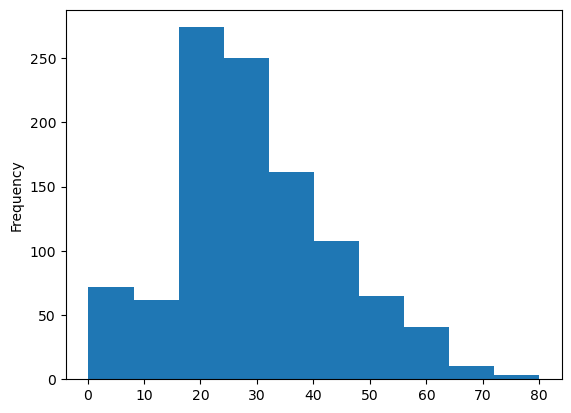

In [87]:
df_X.age.plot.hist(bins=10)

Y analizar si tiene valores nulos o no:

In [33]:
df_X.age.isnull().any()

True

In [34]:
df_X[df_X.age == np.nan]

,sex,age,embarked,pclass_1,pclass_2,pclass_3


Si tiene valores nulos, tenemos que eliminarlos, porque la mayor parte de algoritmos de clasificación no son capaces de lidiar con ellos.

In [35]:
df_X.age[df_X.age.isnull()] = df_X.age.mean()

### sibsp y parch

Por último estudiamos sibsp y parch:

In [ ]:
#df_X.sibsp.value_counts()

In [ ]:
#df_X.parch.value_counts()

Son numéricos, no tienen nulos por lo que están OK.

### Resumen

Hemos revisado todos los valores y los hemos transformado para que:

* No haya valores nulos
* Todos los valores sean numéricos.

In [88]:
df_X.head()

,sex,age,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3
0,0,29.0000,0,0,1,1,0,0
1,1,0.9167,0,0,1,1,0,0
2,0,2.0000,0,0,1,1,0,0
3,1,30.0000,0,0,1,1,0,0
4,0,25.0000,0,0,1,1,0,0


In [ ]:
df_X.isnull().any()

Por último convertimos el dataset a un array de numpy para utilizarlo en `sklearn`:

In [89]:
dataset_X = np.array(df_X)

In [90]:
dataset_X.shape

(1309, 8)

In [91]:
print(dataset_X)

[[ 0.     29.      0.     ...  1.      0.      0.    ]
 [ 1.      0.9167  0.     ...  1.      0.      0.    ]
 [ 0.      2.      0.     ...  1.      0.      0.    ]
 ...
 [ 1.     26.5     1.     ...  0.      0.      1.    ]
 [ 1.     27.      1.     ...  0.      0.      1.    ]
 [ 1.     29.      0.     ...  0.      0.      1.    ]]


## Conjunto de entrenamiento y de test

Como otras veces dividiremos los datos en conjunto de entrenamiento y test:

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

## Árboles de decisión

Los árboles de decisión son uno de los métodos más habituales en la toma de decisión. Su objetivo es representar en forma de árbol todas las posibles opciones de decisión.

<img src="ejemplo_arbol.gif" width="40%"/>

Las ventajas/inconvenientes de los árboles de decisión frente a otros métodos de clasificación:

**Pros**:

* Aumentan su complejidad a medida que aumentan los datos
* Se pueden entender y comprender el modelo de razonamiento*

**Cons**:

* Aumentan su complejidad a medida que aumentan los datos
* A veces tienen mucha inestabilidad. Cambiando un dato cambia el árbol completo.

Podemos entender un poco mejor como funcionan con el siguiente ejemplo (para que funcione el ejemplo es preciso tener instalado el paquete `python-graphviz` y `ipywidgets`, puedes instalarlos con `conda install python-graphviz ipywidgets`):


<div style="background-color:#FFFFCC; padding: 10px; margin:10px; border-radius:10px">
    El paquete <strong>graphviz</strong> no es compatible con sistemas operativos windows (requiere bibliotecas nativas de dibujado de gráficos que están disponibles en este sistema operativo). Si usas un sistema Linux o OSX no tendrás problema. Acuérdate de una vez instalados los paquetes reiniciar jupyter notebook.
    
    
Si usas windows, no te preocupes, veremos el ejemplo en clase y es simplemente un refuerzo a la explicación. Puedes pasar a la siguiente línea.
</div>

In [50]:
%matplotlib inline
plot_tree_interactive()

NameError: name 'plot_tree_interactive' is not defined

Existen multitud de algoritmos basados en árboles de clasificación, en `sklearn` podemos utilizar árboles de clasificación de la siguiente manera:

In [93]:
from sklearn import tree
decission_tree = tree.DecisionTreeClassifier()

Su funcionamiento es análogo a otros algoritmos de clasificación:

In [94]:
decission_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Podemos obtener su porcentaje de acierto de la siguiente manera:

In [95]:
decission_tree.score(X_test, y_test)

0.7938931297709924

In [96]:
y_predicted = decission_tree.predict(X_test)

Y la matriz de confusión:

In [97]:
confusion_matrix(y_test,y_predicted)

array([[204,  20],
       [ 61, 108]], dtype=int64)

## RandomForests

Un algoritmo que da muy buenos resultados son los random forests. La idea subyacente de este algoritmo es muy sencilla: Se cogen diferentes partes de los datos y por cada una de ella se entrena una árbol. Cuando se va a evaluar una nueva instancia, se la somete a todos árboles generados y se promedian los resultados.

Este algoritmo permite que entrenar distintos árboles que tengan en cuenta muy diferentes partes de los datos.

In [98]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

In [99]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [100]:
random_forest.score(X_test, y_test)

0.7837150127226463

In [101]:
import pickle

pickle.dump(random_forest,open('rf_model.pkl','wb'))

In [102]:
random_forest.predict([[0,20,1,0,0,1,0,0]])[0]

1

## Curvas ROC

Un problema que tienen las matrices de confusión y todas las medidas que se derivan de ella, es que todas dependen de un valor de umbral del algoritmo. Es decir, los algoritmos de clasificación en general lo que generan es una probabilidad de pertenencia a cada una de las clases objetivo.

Lo podemos ver en `sklearn` las podemos ver con:

In [60]:
decission_tree.predict_proba(X_test)

array([[1.        , 0.        ],
       [0.66666667, 0.33333333],
       [0.9245283 , 0.0754717 ],
       [0.9245283 , 0.0754717 ],
       [0.85714286, 0.14285714],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.9245283 , 0.0754717 ],
       [0.89473684, 0.10526316],
       [1.        , 0.        ],
       [0.9245283 , 0.0754717 ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [0.89473684, 0.10526316],
       [0.66666667, 0.33333333],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.4       , 0.6       ],
       [1.        , 0.        ],
       [0.78571429, 0.21428571],
       [0.5       , 0.5       ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.

Sobre estas probabilidades se aplica un umbral para determinar a que clase pertenece cada instancia. Lo que pasa es que este enfoque tiene sus limitaciones.

Por ejemplo tenemos una instancia que se ha clasificado de la siguiente manera:

$$P(Clase_A) = 0.51\%$$
$$P(Clase_B) = 0.49\%$$

¿Consideramos con estos datos que tenemos un buen clasificador?

Existe un criterio más potente que consiste en variar el umbral de clasificación y por cada escenario estudiar los resultados. La acumulación de esos resultados se agrega en una curva que se denomina ROC (Receiver Operating Characteristic). 

https://es.wikipedia.org/wiki/Curva_ROC

Para calcular y dibujar estas curvas, está disponible un paquete en scikit que se llama `scikit-plot`. Puedes instalarlo con el siguiente comando: `conda install -c conda-forge scikit-plot`.

Y utilizarlo de la siguente manera:

In [62]:
#import scikitplot as skplt
#import matplotlib.pyplot as plt

#skplt.metrics.plot_roc(y_test, decission_tree.predict_proba(X_test))
#plt.show()

ImportError: cannot import name 'interp' from 'scipy' (c:\ProgramData\anaconda3\envs\mioti_mlops\Lib\site-packages\scipy\__init__.py)

Las curvas ROC estudian la relación entre `True positive rate` o comúnmente llamada la sensibilidad: 

$$VPR=\frac{VP}{P}=\frac{VP}{(VP+FN)}$$

Y el `False positive rate`:

$$FPR = \frac{FP}{N} = \frac{FP}{(FP+VN)}$$

Es una manera resumida de ver la "capacidad de separabilidad" del clasificador. Ya no vale que clasifique bien, sino que tiene que diferenciar "claramente" los casos.

Una buena medida de calidad de un clasificador es el área bajo la curva (AUC) de la curva ROC. Que es un valor entre $0.5$ y $1$. Donde $0.5$ es un clasificador aleatorio y $1$ un clasificador perfecto.

In [67]:
my_array=[]
my_array.append([1,1])
my_array

[[1, 1]]

In [71]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         1309 non-null   int64  
 1   age         1309 non-null   float64
 2   pclass_1    1309 non-null   bool   
 3   pclass_2    1309 non-null   bool   
 4   pclass_3    1309 non-null   bool   
 5   embarked_C  1309 non-null   bool   
 6   embarked_Q  1309 non-null   bool   
 7   embarked_S  1309 non-null   bool   
dtypes: bool(6), float64(1), int64(1)
memory usage: 28.3 KB
